# Pre settings

In [1]:
!ls ../input/google-play-reviews/reviews.csv -a

../input/google-play-reviews/reviews.csv


# Setup

In [2]:
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torch import nn

import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams

import matplotlib.pyplot as plt
from matplotlib import rc

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

from collections import defaultdict
from textwrap import wrap

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)
sns.set_palette(sns.color_palette("Paired"))

rcParams['figure.figsize'] = 12,8
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(device)

cuda:0


# Read Dataset

In [3]:
DATA_PATH = "/kaggle/input/google-play-reviews/reviews.csv"

In [4]:
df = pd.read_csv(DATA_PATH)

In [5]:
df.head(2)

,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,sortOrder,appId
0,Andrew Thomas,https://lh3.googleusercontent.com/a-/AOh14GiHd...,Update: After getting a response from the deve...,1,21,4.17.0.3,2020-04-05 22:25:57,"According to our TOS, and the term you have ag...",2020-04-05 15:10:24,most_relevant,com.anydo
1,Craig Haines,https://lh3.googleusercontent.com/-hoe0kwSJgPQ...,Used it for a fair amount of time without any ...,1,11,4.17.0.3,2020-04-04 13:40:01,It sounds like you logged in with a different ...,2020-04-05 15:11:35,most_relevant,com.anydo


In [6]:
df.shape

(15746, 11)

In [7]:
# Map sentiment scores to categories
def map_sentiment_scores(score_value):
    score_value = int(score_value)
    if score_value <= 2:
        return 0
    elif score_value == 3:
        return 1
    else:
        return 2

In [8]:
df['sentiment'] = df.score.apply(map_sentiment_scores)
class_names = ['negative', 'neutral', 'positive']

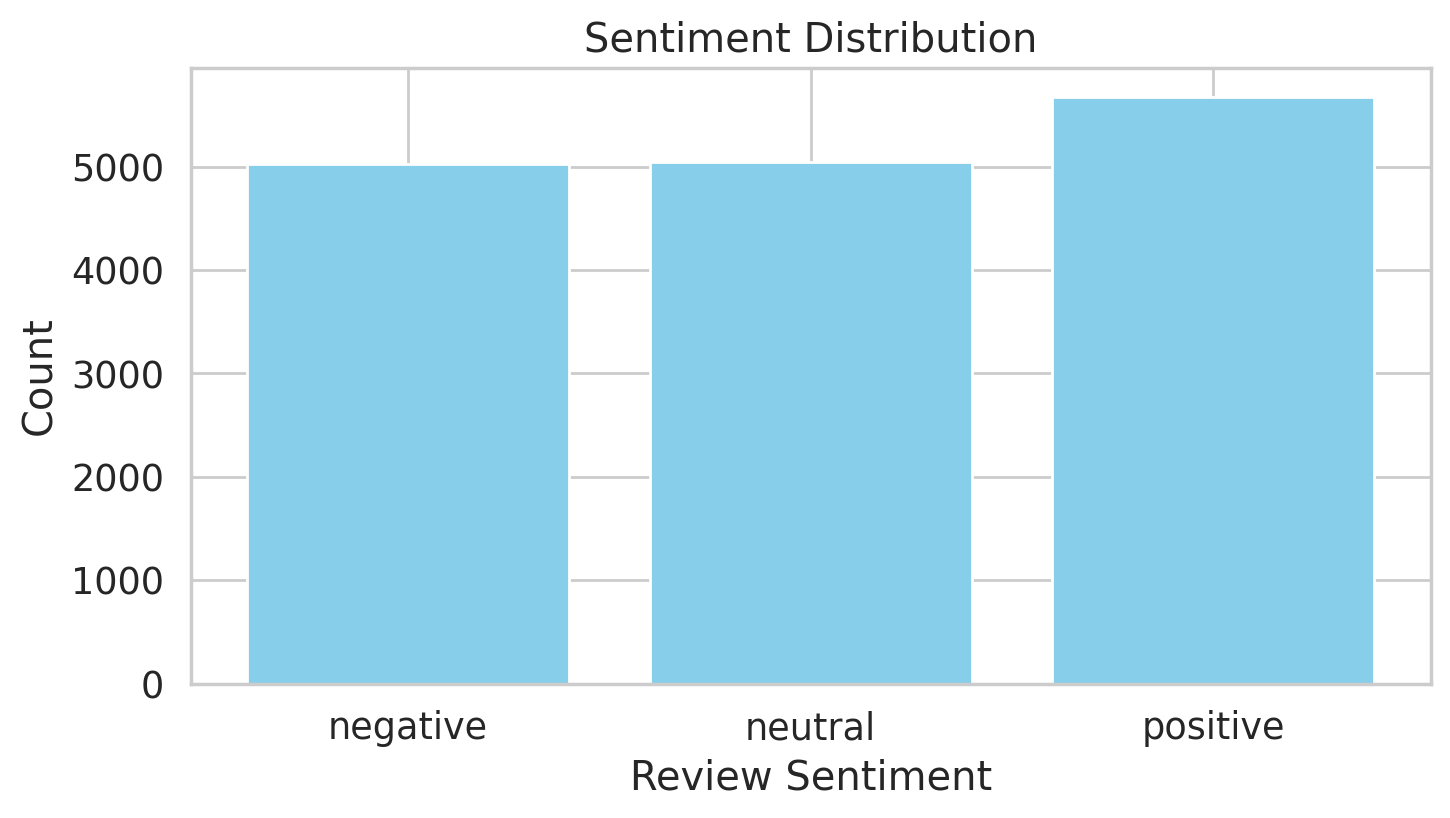

In [9]:
# Count the occurrences of each sentiment
sentiment_counts = df['sentiment'].value_counts().sort_index()

# Set up class names and their respective counts
class_names = ['negative', 'neutral', 'positive']
class_counts = [sentiment_counts.get(i, 0) for i in range(len(class_names))]

# Plotting with Matplotlib
fig, ax = plt.subplots()
fig.set_size_inches(8, 4)
ax.bar(class_names, class_counts, color='skyblue')
ax.set_xlabel('Review Sentiment')
ax.set_ylabel('Count')
ax.set_title('Sentiment Distribution')

plt.show()

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


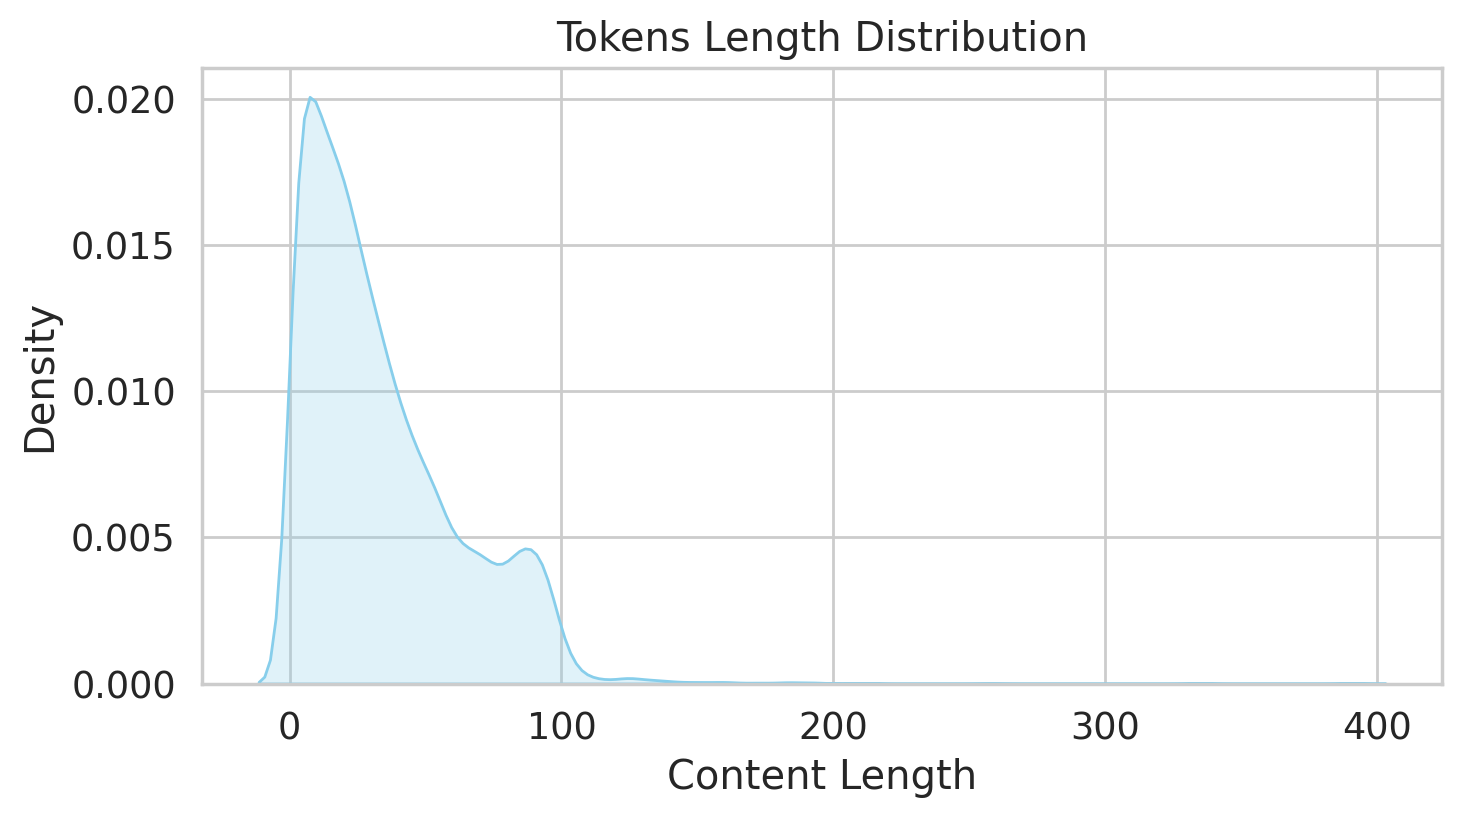

In [10]:
# Calculate the lengths of the content
lengths = [len(e) for e in df["content"].str.split(" ").values]

# Plotting with Seaborn's kdeplot
fig, ax = plt.subplots()
fig.set_size_inches(8, 4)
sns.kdeplot(lengths, ax=ax, color='skyblue', fill=True)
ax.set_xlabel('Content Length')
ax.set_ylabel('Density')
ax.set_title('Tokens Length Distribution')

plt.show()

# Model

### Define Transformer

In [11]:
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'

### Get respective Tokenizer

In [12]:
from transformers import AutoTokenizer

In [13]:
tokenizer = AutoTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


### Example of tokenization

In [14]:
sample_txt = "Hi! My name is Chesar and I'm a Machine Learning Engineer from Peru!"
tokens = tokenizer.tokenize(sample_txt)
token_ids = tokenizer.convert_tokens_to_ids(tokens)

In [15]:
print(f' Sentence: {sample_txt}')
print(f'   Tokens: {tokens}')
print(f'Token IDs: {token_ids}')

 Sentence: Hi! My name is Chesar and I'm a Machine Learning Engineer from Peru!
   Tokens: ['Hi', '!', 'My', 'name', 'is', 'Ch', '##es', '##ar', 'and', 'I', "'", 'm', 'a', 'Machine', 'Learning', 'Engineer', 'from', 'Peru', '!']
Token IDs: [8790, 106, 1422, 1271, 1110, 20394, 1279, 1813, 1105, 146, 112, 182, 170, 7792, 9681, 8252, 1121, 7022, 106]


In [16]:
sample_txt = "Hi! My name is Chesar and I'm a Machine Learning Engineer from Peru!"
tokens = tokenizer.tokenize(sample_txt, add_special_tokens=True)
token_ids = tokenizer.convert_tokens_to_ids(tokens)

In [17]:
print(f' Sentence: {sample_txt}')
print(f'   Tokens: {tokens}')
print(f'Token IDs: {token_ids}')

 Sentence: Hi! My name is Chesar and I'm a Machine Learning Engineer from Peru!
   Tokens: ['[CLS]', 'Hi', '!', 'My', 'name', 'is', 'Ch', '##es', '##ar', 'and', 'I', "'", 'm', 'a', 'Machine', 'Learning', 'Engineer', 'from', 'Peru', '!', '[SEP]']
Token IDs: [101, 8790, 106, 1422, 1271, 1110, 20394, 1279, 1813, 1105, 146, 112, 182, 170, 7792, 9681, 8252, 1121, 7022, 106, 102]


- `[CLS]` token stands for the token that marks the very beggining of the sentence and it's called the classification token.
- `[SEP]` token stands for the token that marks the separation between sentences and it's called the separator token.

### Example of encoding (tokenization + encoding)

In [18]:
print(sample_txt)

Hi! My name is Chesar and I'm a Machine Learning Engineer from Peru!


In [19]:
encoding = tokenizer.encode_plus(
    sample_txt,
    max_length=32,
    truncation=True,
    add_special_tokens=True, # Add '[CLS]' and '[SEP]'
    return_token_type_ids=False,
    padding=True,
    return_attention_mask=True,
    return_tensors='pt' # Return PyTorch tensors)
)

In [20]:
# Detailed explanation of the output
print(f'Encoding keys: {encoding.keys()}')

# Length of input_ids
input_ids = encoding['input_ids'][0].tolist()
print(f'Length of input_ids: {len(input_ids)}')
print(f'Input IDs: {input_ids}')

# Length and values of attention mask
attention_mask = encoding['attention_mask'][0].tolist()
print(f'Length of attention_mask: {len(attention_mask)}')
print(f'Attention Mask: {attention_mask}')

# Tokens converted back from IDs
tokens = tokenizer.convert_ids_to_tokens(input_ids)
print(f'Tokens: {tokens}')

Encoding keys: dict_keys(['input_ids', 'attention_mask'])
Length of input_ids: 21
Input IDs: [101, 8790, 106, 1422, 1271, 1110, 20394, 1279, 1813, 1105, 146, 112, 182, 170, 7792, 9681, 8252, 1121, 7022, 106, 102]
Length of attention_mask: 21
Attention Mask: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Tokens: ['[CLS]', 'Hi', '!', 'My', 'name', 'is', 'Ch', '##es', '##ar', 'and', 'I', "'", 'm', 'a', 'Machine', 'Learning', 'Engineer', 'from', 'Peru', '!', '[SEP]']


### Visualization of the token counts in the dataset}

In [21]:
# Token lengths calculation
token_lens = []
for txt in df['content']:
    tokens = tokenizer.encode(txt, truncation=True, max_length=512)
    token_lens.append(len(tokens))

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


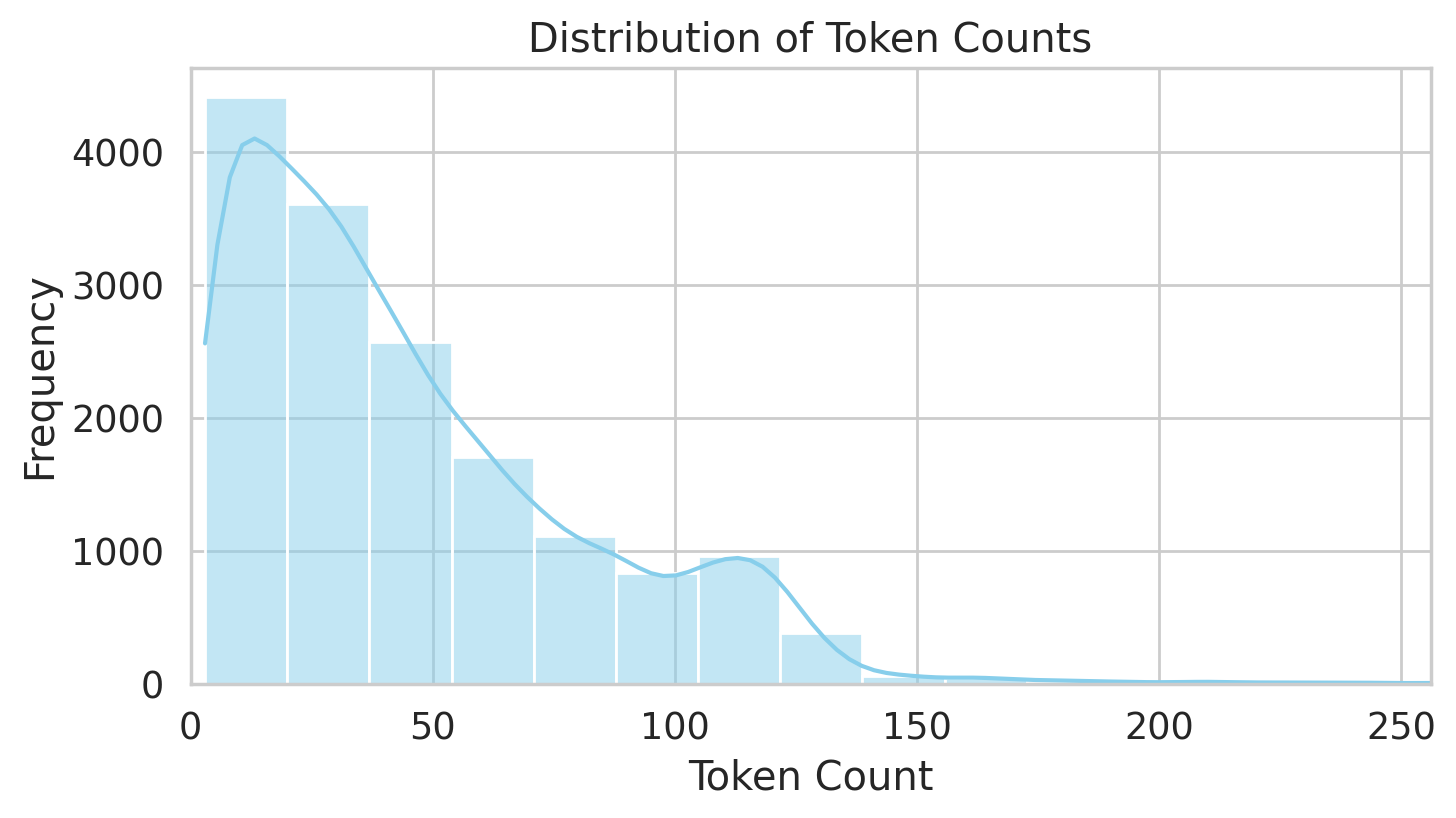

In [22]:
# Object-oriented plotting with Seaborn
fig, ax = plt.subplots(figsize=(10, 6))
fig.set_size_inches(8, 4)
sns.histplot(token_lens, bins=30, kde=True, color='skyblue', ax=ax)
ax.set_xlim([0, 256])
ax.set_xlabel('Token Count')
ax.set_ylabel('Frequency')
ax.set_title('Distribution of Token Counts')

plt.show()

## Dataset Utility Class

In [23]:
from torch.utils.data import Dataset

In [24]:
MAX_LEN = 160
BATCH_SIZE = 16


class GPReviewDataset(Dataset):
    def __init__(self, reviews, targets, tokenizer, max_len, include_raw_text=False):
        self.reviews = reviews
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.include_raw_text = include_raw_text

    def __len__(self):
        return len(self.reviews)

    def __getitem__(self, item):
        review = str(self.reviews[item])
        target = self.targets[item]
        encoding = self.tokenizer.encode_plus(
            review,
            add_special_tokens = True,
            max_length = self.max_len,
            return_token_type_ids = False,
            return_attention_mask = True,
            truncation = True,
            padding = 'max_length',
            return_tensors = 'pt'
        )

        output = {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'targets': torch.tensor(target, dtype=torch.long)
        }
        if self.include_raw_text:
            output['review_text'] = review

        return output

In [25]:
def create_data_loader(df, tokenizer, max_len=MAX_LEN, batch_size=BATCH_SIZE, include_raw_text=False):
    ds = GPReviewDataset(
        reviews = df.content.to_list(),
        targets = df.sentiment.to_list(),
        tokenizer = tokenizer,
        max_len = max_len,
        include_raw_text = include_raw_text)
    return DataLoader(ds, batch_size=batch_size)

In [26]:
df_train, df_test = train_test_split(df, test_size = 0.1, random_state = RANDOM_SEED)
df_val, df_test = train_test_split(df_test, test_size = 0.5, random_state = RANDOM_SEED)

In [27]:
print(df_train.shape, df_val.shape, df_test.shape)

(14171, 12) (787, 12) (788, 12)


In [28]:
train_data_loader = create_data_loader(df_train, tokenizer)
val_data_loader = create_data_loader(df_val, tokenizer, include_raw_text=True)
test_data_loader = create_data_loader(df_test, tokenizer, include_raw_text=True)

In [29]:
type(train_data_loader)

torch.utils.data.dataloader.DataLoader

In [30]:
#Testing to see if the data loader works appropriately
data = next(iter(train_data_loader))

In [31]:
# Print the keys in the batch
print("Batch Keys:", data.keys())

# Print the shape of the 'input_ids' tensor
print(f"Shape of 'input_ids' tensor: {data['input_ids'].shape} (Batch Size, Max Length)")

# Print the shape of the 'attention_mask' tensor
print(f"Shape of 'attention_mask' tensor: {data['attention_mask'].shape} (Batch Size, Max Length)")

# Print the shape of the 'targets' tensor
print(f"Shape of 'targets' tensor: {data['targets'].shape} (Batch Size)")

Batch Keys: dict_keys(['input_ids', 'attention_mask', 'targets'])
Shape of 'input_ids' tensor: torch.Size([16, 160]) (Batch Size, Max Length)
Shape of 'attention_mask' tensor: torch.Size([16, 160]) (Batch Size, Max Length)
Shape of 'targets' tensor: torch.Size([16]) (Batch Size)


## Model Utility Class

### Get the model (BERT)

In [32]:
from transformers import AutoModel

In [33]:
bert_model = AutoModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

In [34]:
class SentimentClassifier(nn.Module):
    def __init__(self, n_classes):
        super(SentimentClassifier, self).__init__()
        self.bert = AutoModel.from_pretrained(PRE_TRAINED_MODEL_NAME,return_dict=False)
        self.drop = nn.Dropout(p = 0.3)
        self.out = nn.Linear(self.bert.config.hidden_size, n_classes)

    def forward(self, input_ids, attention_mask):
        _, pooled_output = self.bert(
            input_ids = input_ids,
            attention_mask= attention_mask
        )
        output = self.drop(pooled_output)
        return self.out(output)

In [35]:
print(f"Device: {device}")

Device: cuda:0


In [36]:
model = SentimentClassifier(len(class_names))
model = model.to(device)

In [37]:
# An evaluation run of the model
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)

In [38]:
logits = model(input_ids, attention_mask)

In [39]:
probs = F.softmax( model(input_ids, attention_mask) , dim = 1)

In [40]:
max_values, max_indices = torch.max(probs, dim=1)

In [41]:
print("Probabilities:\n", probs)
print("\nSelected Max Values:\n", max_values)
print("\nIndices of Max Values:\n", max_indices)

Probabilities:
 tensor([[0.3242, 0.3107, 0.3651],
        [0.2899, 0.1697, 0.5404],
        [0.2398, 0.3585, 0.4018],
        [0.2251, 0.2105, 0.5644],
        [0.2434, 0.2635, 0.4930],
        [0.2859, 0.3294, 0.3846],
        [0.2397, 0.1981, 0.5622],
        [0.2057, 0.4346, 0.3597],
        [0.1129, 0.2898, 0.5974],
        [0.2386, 0.3620, 0.3994],
        [0.2083, 0.2349, 0.5568],
        [0.2924, 0.2379, 0.4696],
        [0.3299, 0.2210, 0.4491],
        [0.3884, 0.3104, 0.3012],
        [0.2811, 0.1587, 0.5601],
        [0.4212, 0.2173, 0.3615]], device='cuda:0', grad_fn=<SoftmaxBackward0>)

Selected Max Values:
 tensor([0.3651, 0.5404, 0.4018, 0.5644, 0.4930, 0.3846, 0.5622, 0.4346, 0.5974,
        0.3994, 0.5568, 0.4696, 0.4491, 0.3884, 0.5601, 0.4212],
       device='cuda:0', grad_fn=<MaxBackward0>)

Indices of Max Values:
 tensor([2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 0, 2, 0], device='cuda:0')


# Training

### Training Loop Utility Functions

In [42]:
from transformers import get_linear_schedule_with_warmup
from torch import optim

In [43]:
EPOCHS = 10

optimizer = optim.AdamW(model.parameters(), lr= 2e-5)

total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps = 0,
    num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

In [44]:
def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
    model=model.train()

    losses = []
    correct_predictions = 0

    for batch in data_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        targets = batch["targets"].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        _, preds = torch.max(outputs, dim = 1)
        loss = loss_fn(outputs, targets)
        correct_predictions += torch.sum(preds == targets).cpu()
        losses.append(loss.item())

        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

    return correct_predictions/n_examples, np.mean(losses)

In [45]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
    model = model.eval()
    losses = []
    correct_predictions = 0

    with torch.no_grad():
        for d in data_loader:
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            _,preds = torch.max(outputs, dim = 1)

            loss = loss_fn(outputs, targets)
            correct_predictions += torch.sum(preds == targets).cpu()
            losses.append(loss.item())
    return correct_predictions/n_examples, np.mean(losses)

## Training Loop

Epoch 1/ 10
---------------
Train loss 0.7776782665040101 accuracy 0.638134241104126
Val loss 0.6611144423484803 accuracy 0.7204574346542358
Epoch 2/ 10
---------------
Train loss 0.5201450474139799 accuracy 0.794227659702301
Val loss 0.6268640725314617 accuracy 0.792884349822998
Epoch 3/ 10
---------------
Train loss 0.3296520869188751 accuracy 0.8870933651924133
Val loss 0.6460151499882341 accuracy 0.841168999671936
Epoch 4/ 10
---------------
Train loss 0.22888417030699365 accuracy 0.9321148991584778
Val loss 0.7147117509692907 accuracy 0.8526048064231873
Epoch 5/ 10
---------------
Train loss 0.1653145800862865 accuracy 0.9563897848129272
Val loss 0.7300557118281722 accuracy 0.8602287173271179
Epoch 6/ 10
---------------
Train loss 0.11860143447491397 accuracy 0.9682450294494629
Val loss 0.7867152294446714 accuracy 0.8767471313476562
Epoch 7/ 10
---------------
Train loss 0.08928247944346228 accuracy 0.9753016829490662
Val loss 0.8735304417728912 accuracy 0.8703938722610474
Epoch 8

(0.0, 1.0)

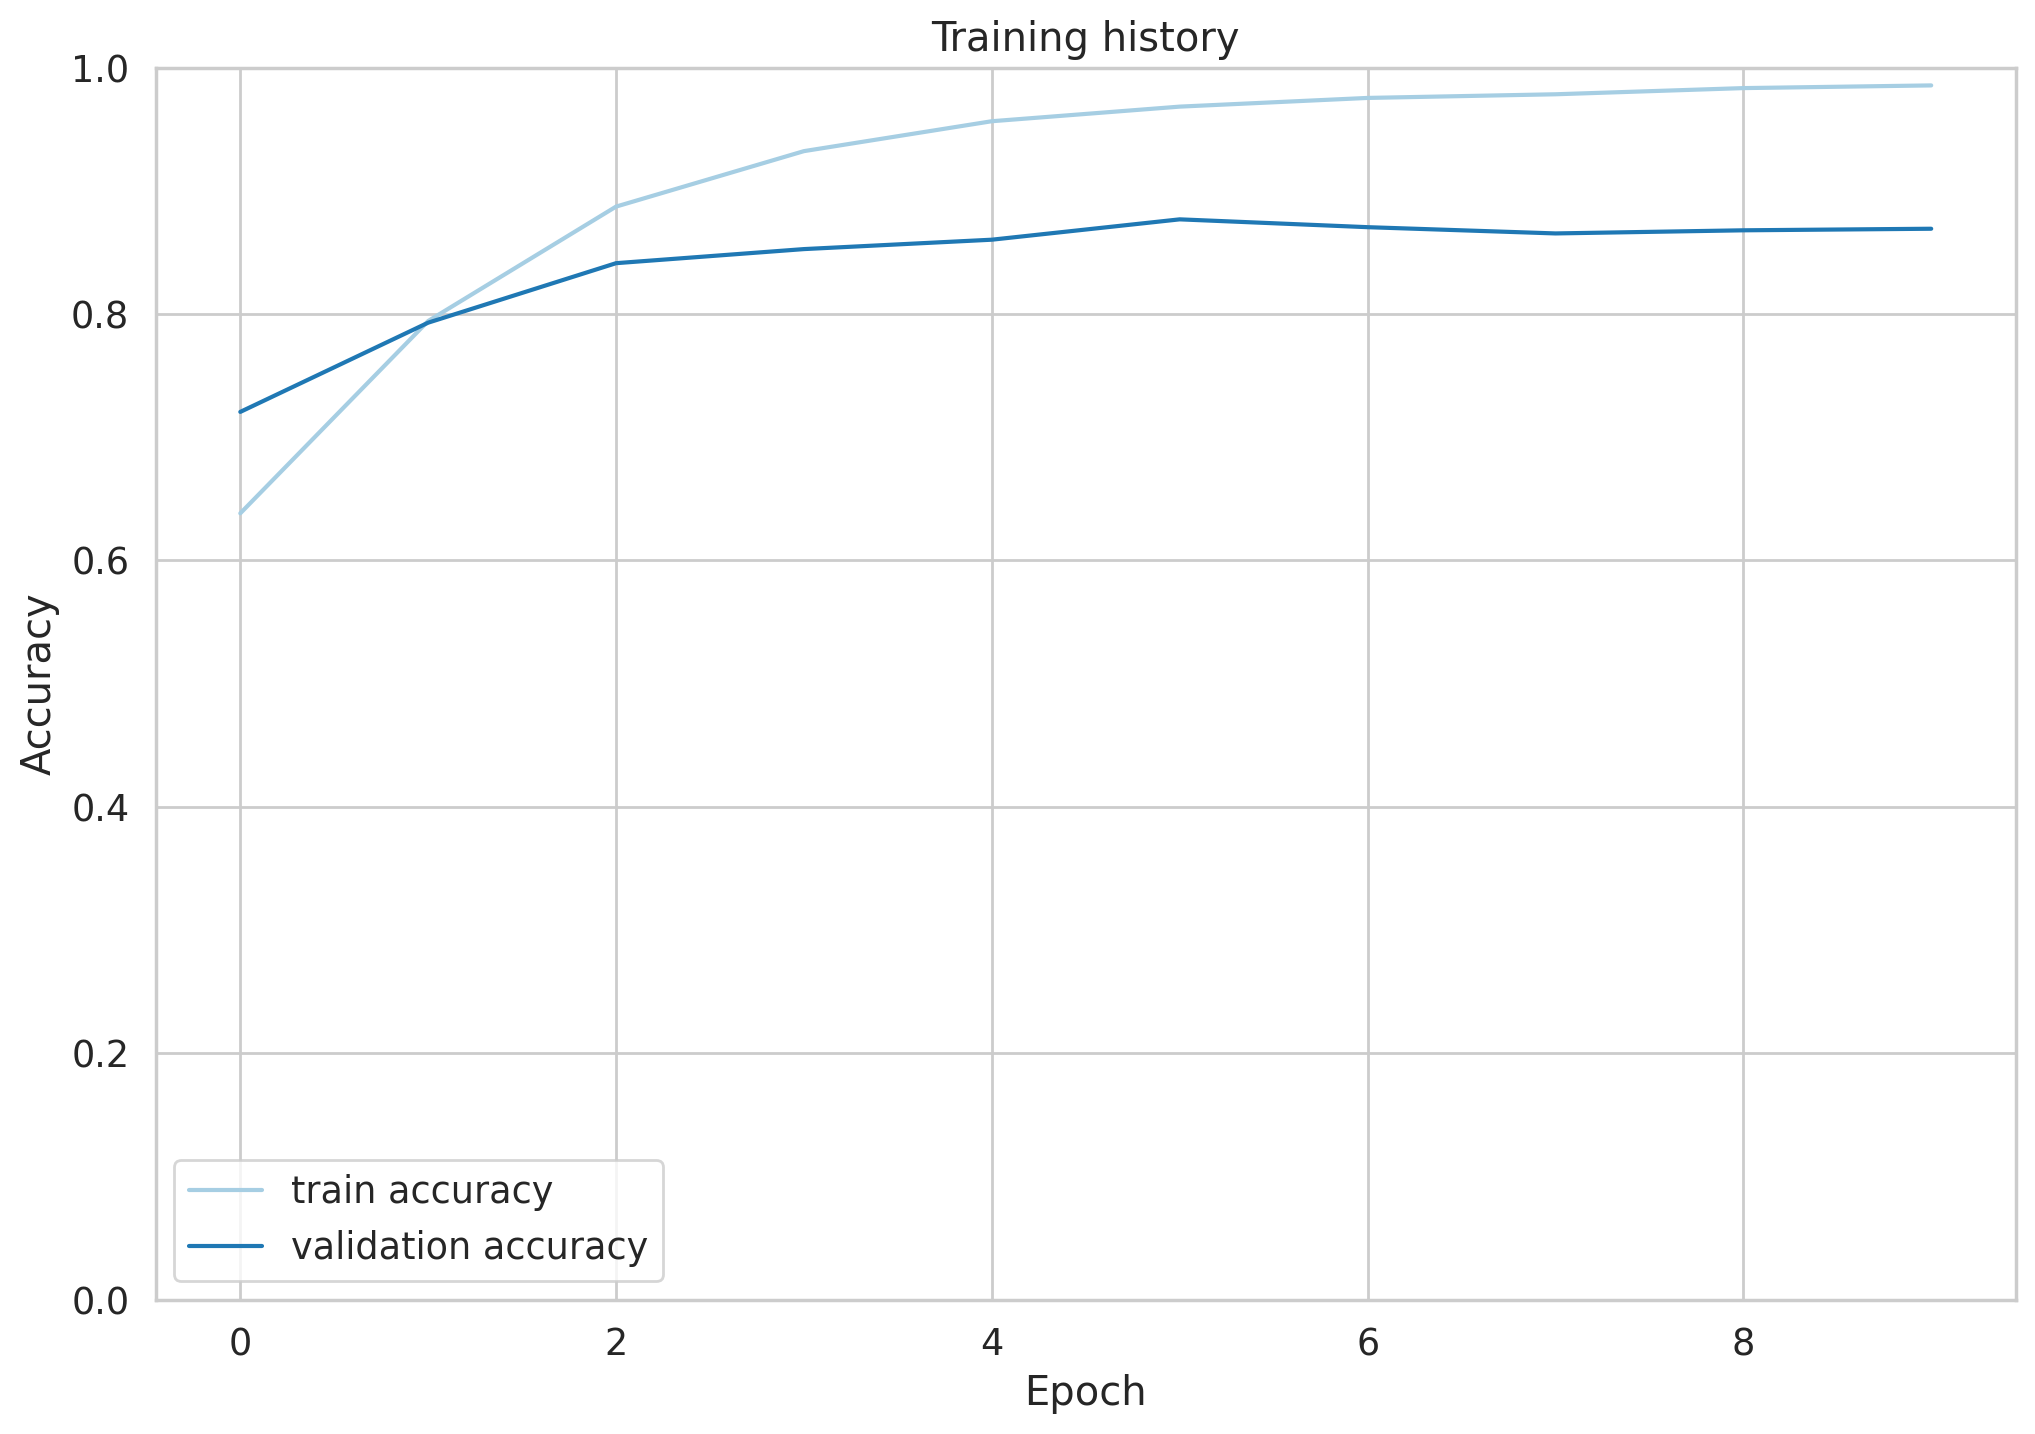

In [46]:
%%time
history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):
    print(f'Epoch {epoch + 1}/ {EPOCHS}')
    print('-'*15)
    train_acc, train_loss = train_epoch(model, train_data_loader, loss_fn, optimizer, device, scheduler, len(df_train))
    print(f'Train loss {train_loss} accuracy {train_acc}')

    val_acc, val_loss = eval_model(model, val_data_loader, loss_fn, device, len(df_val))
    print(f'Val loss {val_loss} accuracy {val_acc}')

    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)

    if val_acc>best_accuracy:
        torch.save(model.state_dict(), 'best_model_state.bin')
        best_accuracy = val_acc

plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0,1])

## Visualizing Training/Validation Losses

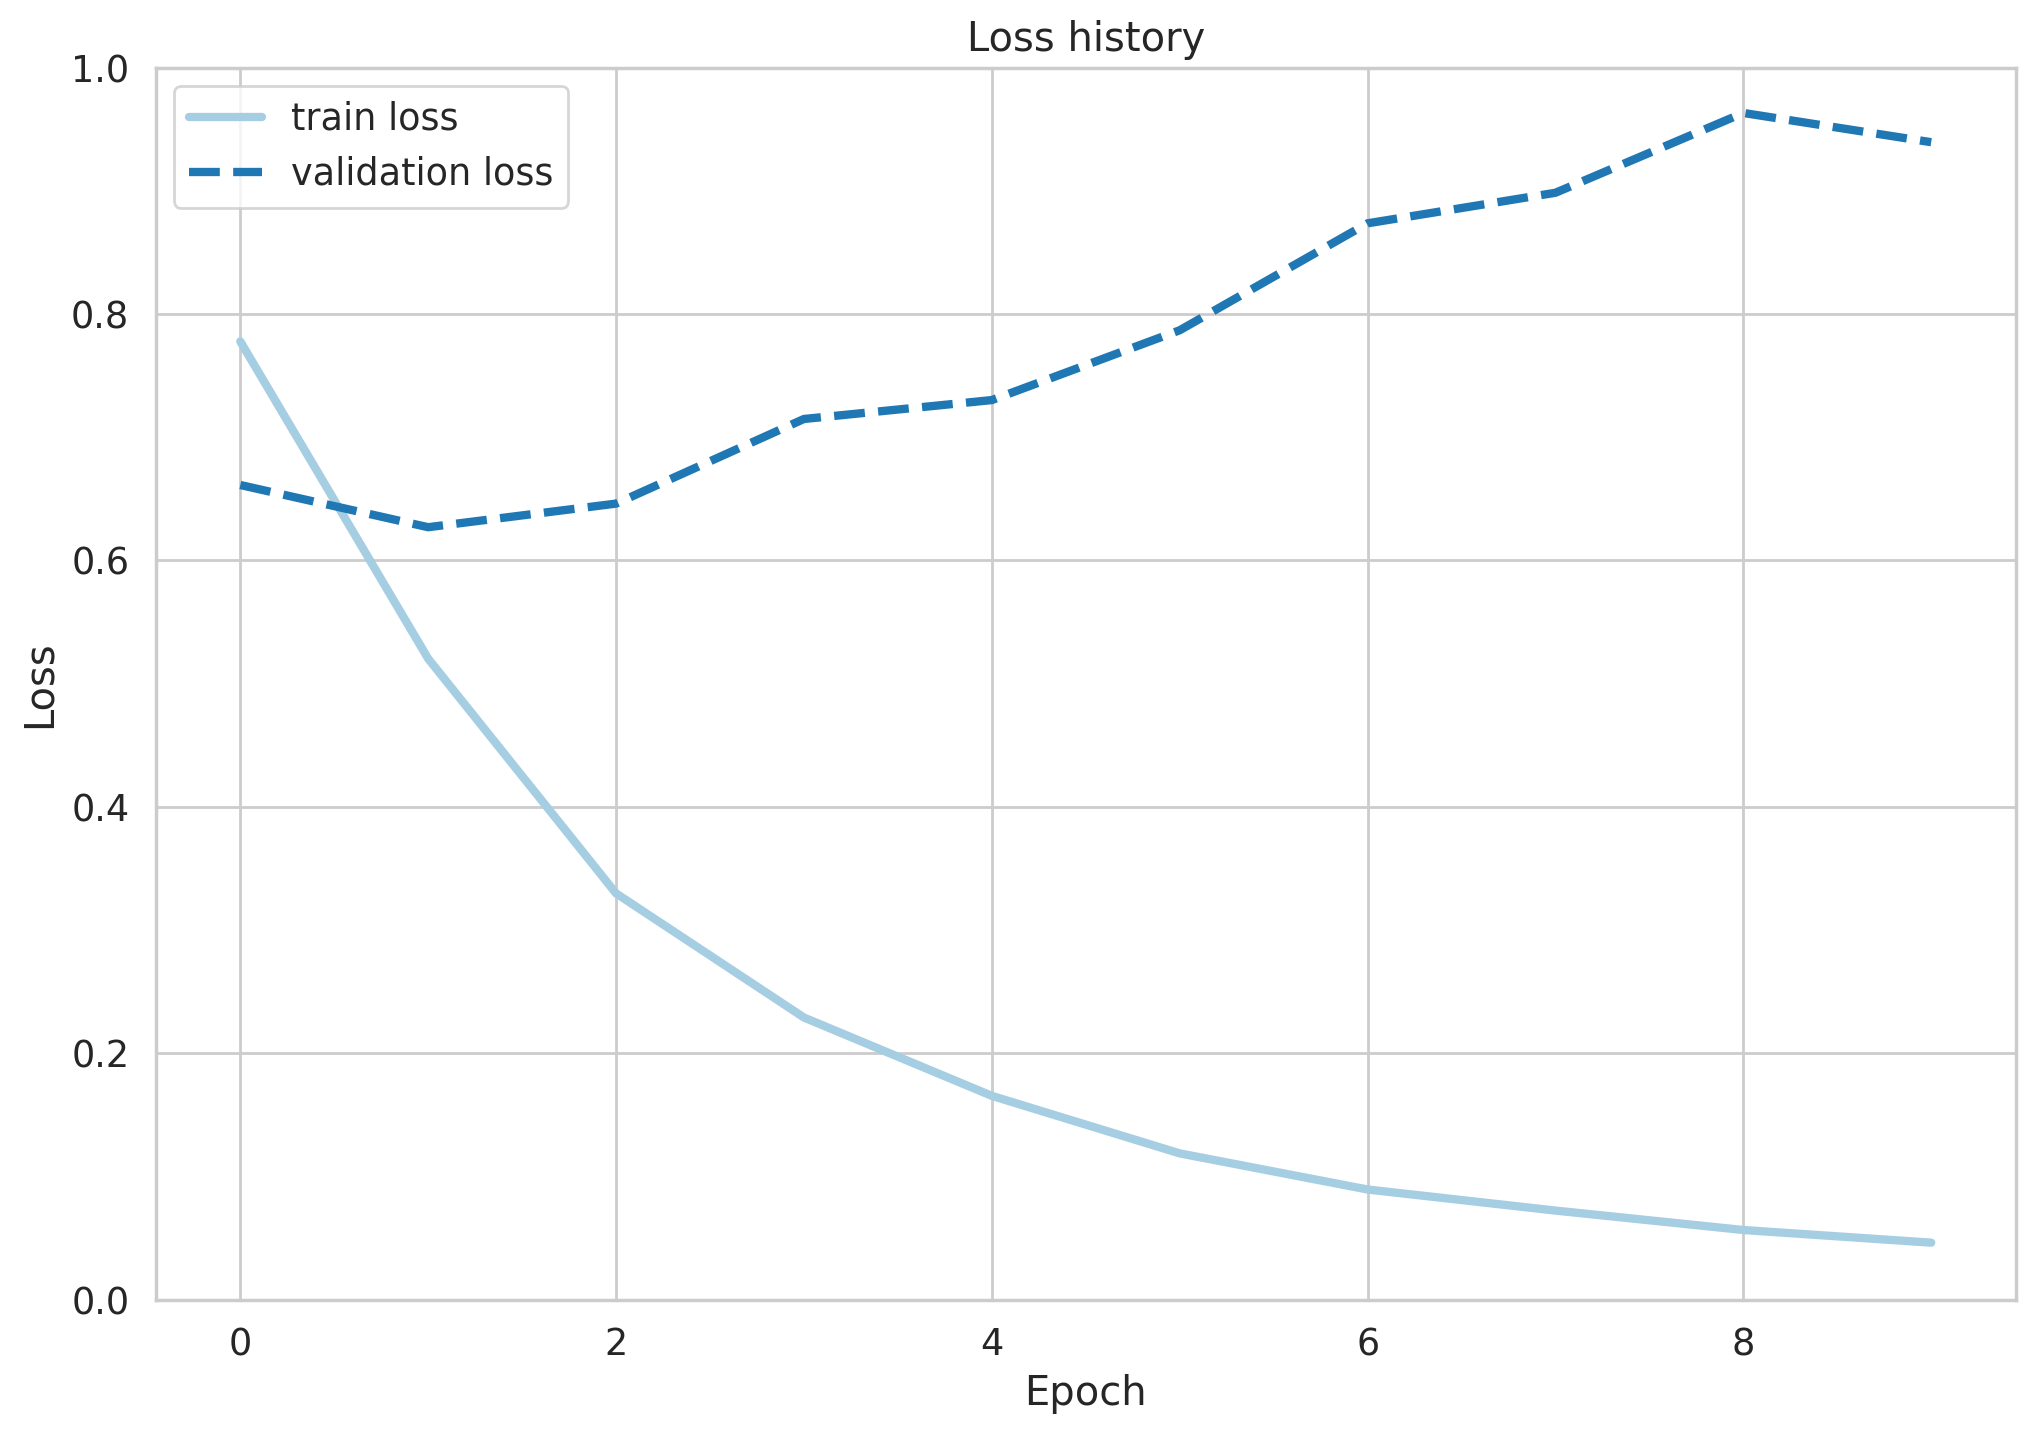

In [47]:
plt.plot(history['train_loss'], label='train loss',linewidth=3)
plt.plot(history['val_loss'], '--',label='validation loss',linewidth=3)

plt.title('Loss history')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

In [48]:
test_acc, _ = eval_model(model, test_data_loader, loss_fn, device, len(df_test))
print(f'Test Accuracy {test_acc.item()}')

Test Accuracy 0.8845177888870239


# Model Evaluation

In [49]:
def get_predictions(model, data_loader):
    model = model.eval()
    review_texts = []
    predictions = []
    prediction_probs = []
    real_values = []

    with torch.no_grad():
        for d in data_loader:
            texts = d["review_text"]
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)
            outputs = model(input_ids = input_ids, attention_mask = attention_mask)
            _, preds = torch.max(outputs, dim=1)
            probs = F.softmax(outputs, dim =1)
            review_texts.extend(texts)
            predictions.extend(preds)
            prediction_probs.extend(probs)
            real_values.extend(targets)
    
    predictions = torch.stack(predictions).cpu()
    prediction_probs = torch.stack(prediction_probs).cpu()
    real_values = torch.stack(real_values).cpu()
    return review_texts, predictions, prediction_probs, real_values

In [50]:
def show_confusion_matrix(confusion_matrix):
    hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
    hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation = 0, ha='right')
    hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation = 30, ha='right')
    plt.ylabel('True Sentiment')
    plt.xlabel('Predicted Sentiment')

In [51]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(model, test_data_loader)
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

    negative       0.92      0.85      0.89       245
     neutral       0.82      0.88      0.85       254
    positive       0.92      0.92      0.92       289

    accuracy                           0.88       788
   macro avg       0.89      0.88      0.88       788
weighted avg       0.89      0.88      0.89       788



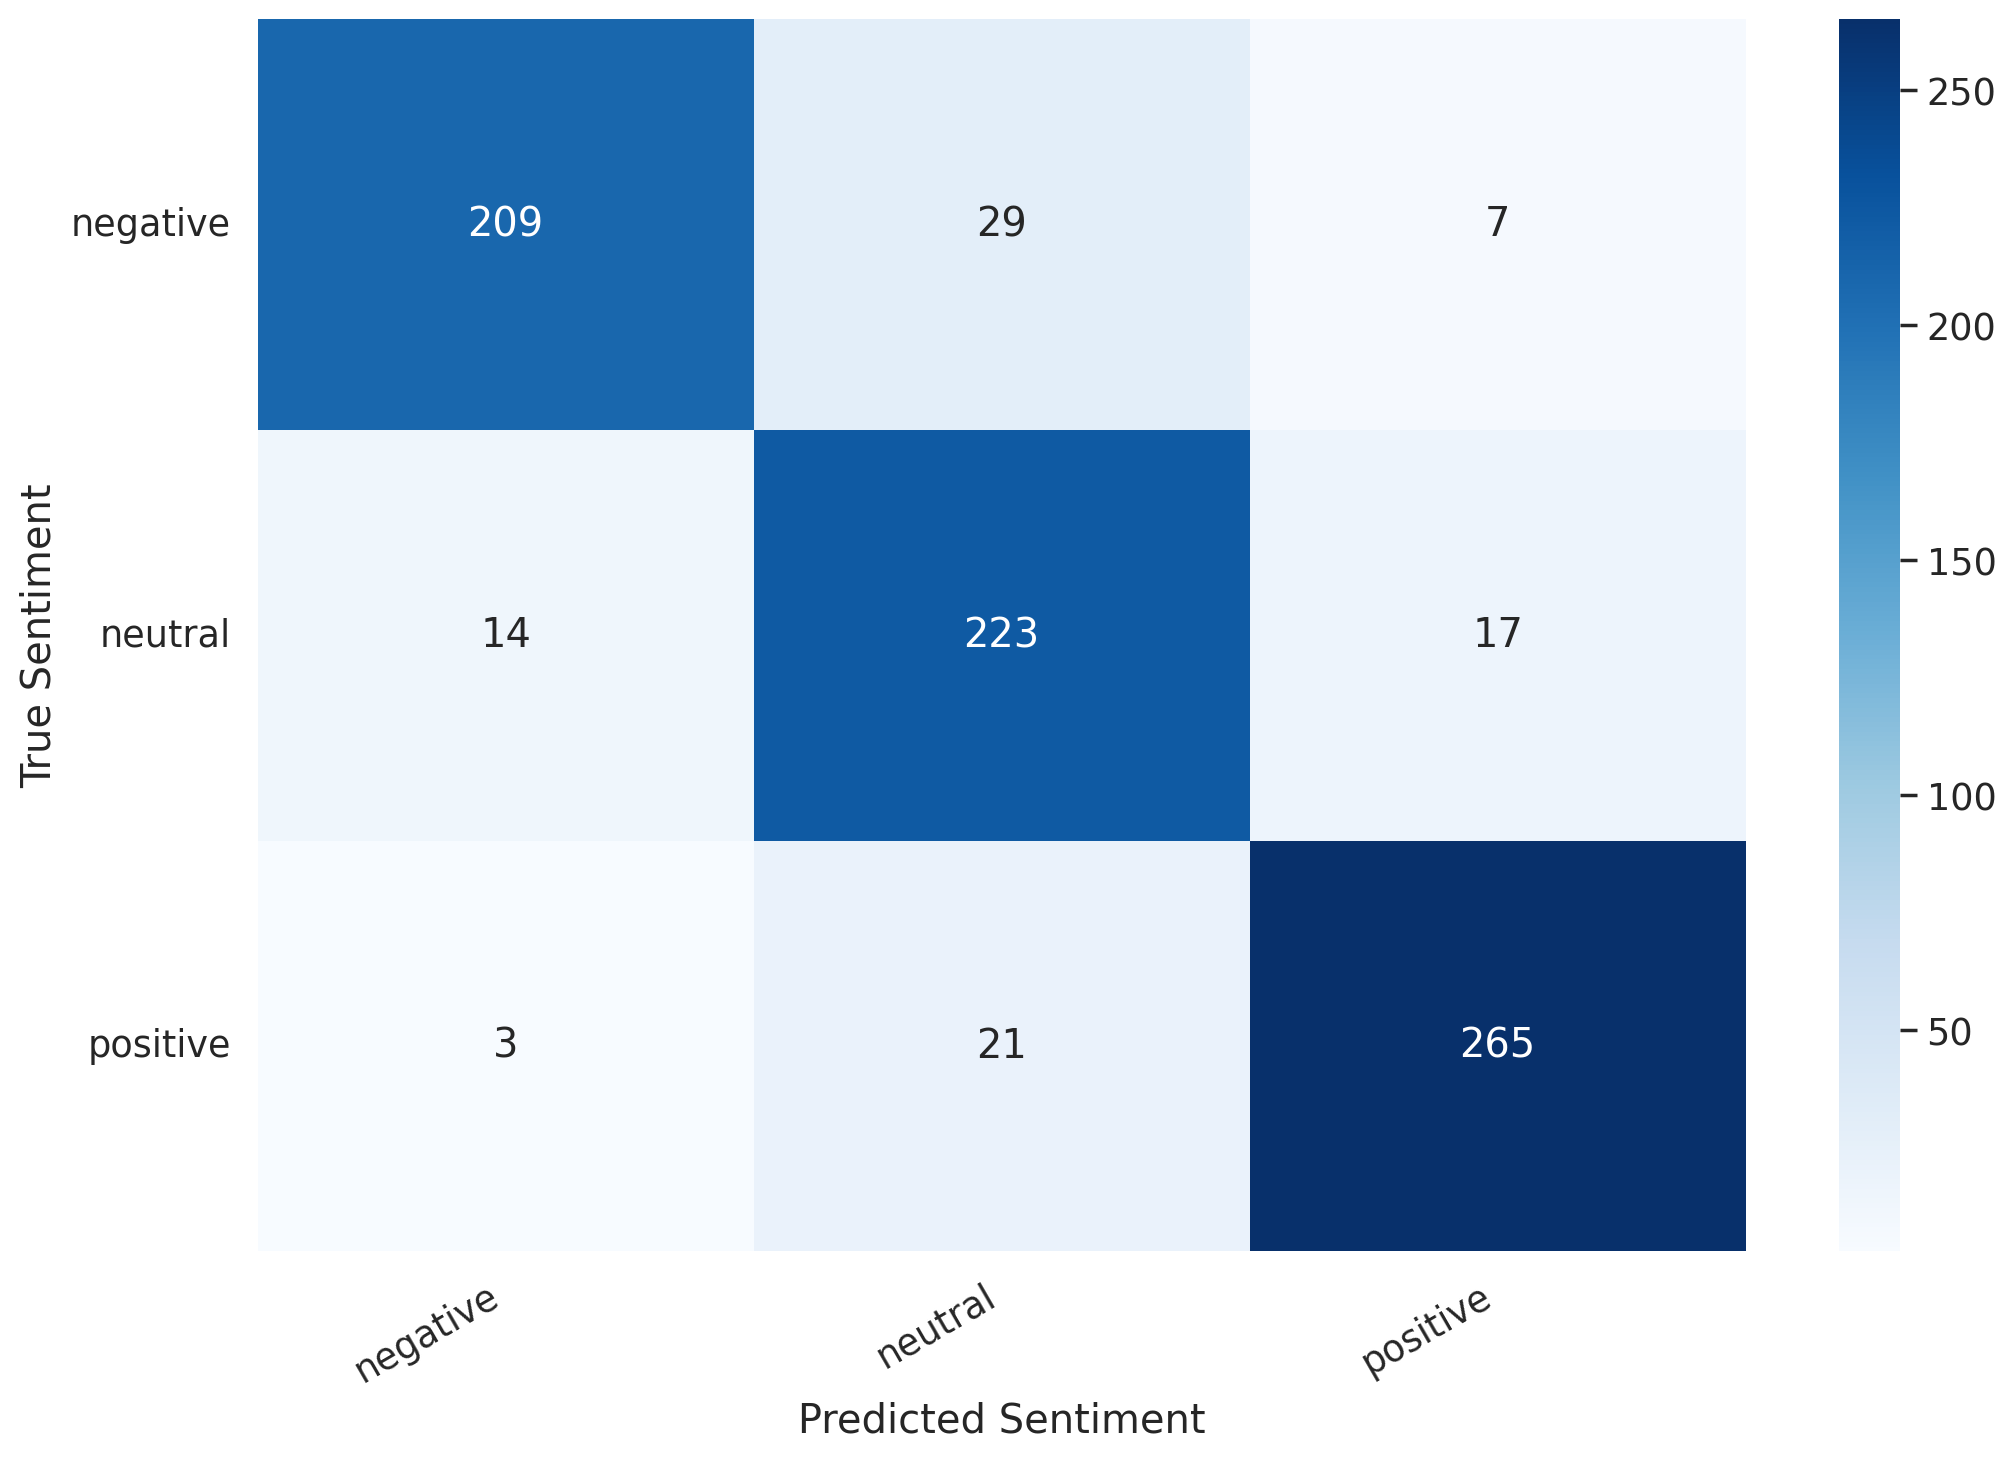

In [52]:
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns = class_names)
show_confusion_matrix(df_cm)

In [53]:
idx = 2
review_text = y_review_texts[idx]
true_sentiment = y_test[idx]
pred_df = pd.DataFrame({'class_names':class_names, 'values':y_pred_probs[idx]})
print("\n".join(wrap(review_text)))
print()
print(f'True Sentiment: {class_names[true_sentiment]}')

I used to use Habitica, and I must say this is a great step up. I'd
like to see more social features, such as sharing tasks - only one
person has to perform said task for it to be checked off, but only
giving that person the experience and gold. Otherwise, the price for
subscription is too steep, thus resulting in a sub-perfect score. I
could easily justify $0.99/month or eternal subscription for $15. If
that price could be met, as well as fine tuning, this would be easily
worth 5 stars.

True Sentiment: neutral


(0.0, 1.0)

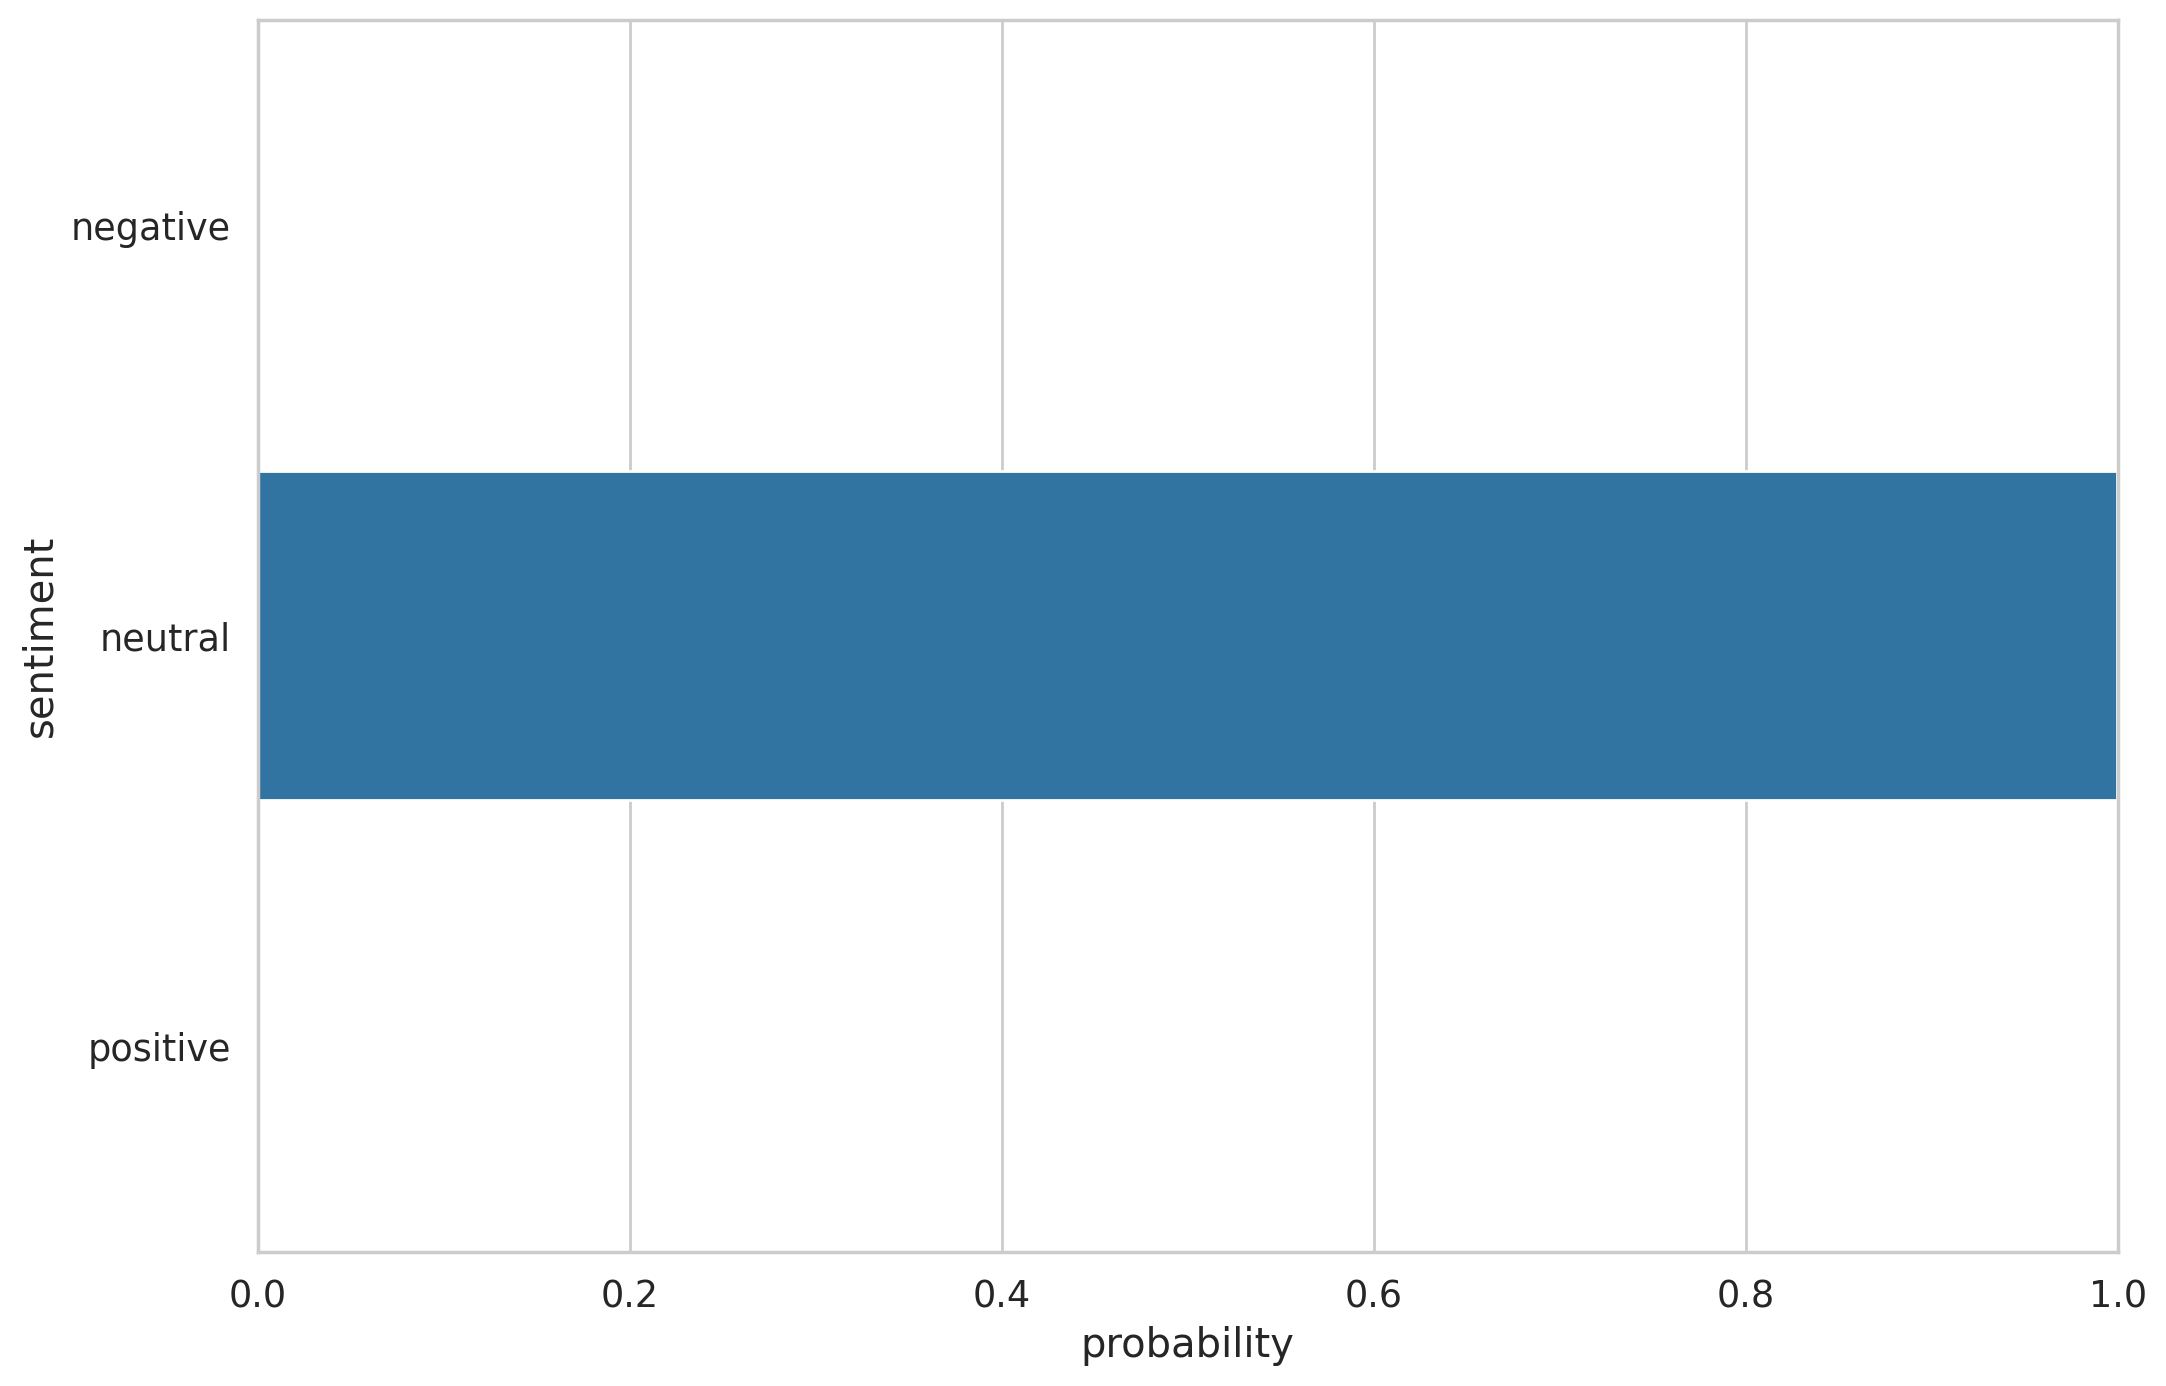

In [54]:
sns.barplot(x='values', y='class_names', data=pred_df, orient='h')
plt.ylabel('sentiment')
plt.xlabel('probability')
plt.xlim([0,1])

In [55]:
review_text = "I love completing my todos! Best app ever!!!"
encoded_review = tokenizer.encode_plus(
    text=review_text,
    max_length=MAX_LEN,
    add_special_tokens=True,
    return_token_type_ids=False,
    padding='max_length',
    return_attention_mask=True,
    truncation=True,
    return_tensors='pt'
)

input_ids = encoded_review['input_ids'].to(device)
attention_mask=encoded_review['attention_mask'].to(device)
output = model(input_ids, attention_mask)
_,prediction = torch.max(output, dim=1)

In [56]:
print(f'Review text: {review_text}')
print(f'Sentiment  : {class_names[prediction]}')

Review text: I love completing my todos! Best app ever!!!
Sentiment  : positive
